# Load Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics.pairwise import cosine_similarity
from typing import List

# load the dataset
animes = pd.read_csv('./data/anime.csv')
ratings = pd.read_csv('./data/rating.csv')

# Preprocessing & Feature Engineering

In [2]:
# selected features only being used
animes = animes[['anime_id', 'type', 'rating', 'members', 'name', 'genre']]
# change column name
animes.columns = ['anime_id', 'type', 'anime_total_rating', 'members', 'name', 'genre']
# dropna
animes = animes.dropna()

animes

,anime_id,type,anime_total_rating,members,name,genre
0,32281,Movie,9.37,200630,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
1,5114,TV,9.26,793665,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
2,28977,TV,9.25,114262,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S..."
3,9253,TV,9.17,673572,Steins;Gate,"Sci-Fi, Thriller"
4,9969,TV,9.16,151266,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S..."
...,...,...,...,...,...,...
12289,9316,OVA,4.15,211,Toushindai My Lover: Minami tai Mecha-Minami,Hentai
12290,5543,OVA,4.28,183,Under World,Hentai
12291,5621,OVA,4.88,219,Violence Gekiga David no Hoshi,Hentai
12292,6133,OVA,4.98,175,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai


In [3]:
# selcted features of rating table
ratings = ratings[['user_id', 'anime_id', 'rating']]
ratings = ratings[ratings['rating'] != -1]
ratings

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [4]:
# join dataframes
data = ratings.merge(animes, on='anime_id', how='inner')
data

,user_id,anime_id,rating,type,anime_total_rating,members,name,genre
0,1,8074,10,TV,7.46,535892,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
1,1,11617,10,TV,7.70,398660,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School"
2,1,11757,10,TV,7.83,893100,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
3,1,15451,10,TV,7.87,266657,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,..."
4,2,11771,10,TV,8.46,338315,Kuroko no Basket,"Comedy, School, Shounen, Sports"
...,...,...,...,...,...,...,...,...
6337141,73515,16512,7,TV,7.06,101266,Devil Survivor 2 The Animation,"Action, Demons, Supernatural"
6337142,73515,17187,9,Movie,7.64,31747,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi"
6337143,73515,22145,10,TV,8.37,122895,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ..."
6337144,73516,790,9,TV,8.03,265005,Ergo Proxy,"Mystery, Psychological, Sci-Fi"


In [5]:
# 유저 정보가 없으므로, 유저의 평점 패턴에서 유저의 피쳐 추출 (평균 평점 및 평점을 내린 수)
user_avg_rating = data.groupby('user_id')['rating'].mean().rename('User-AvgRating')
user_num_ratings = data.groupby('user_id')['rating'].count().rename('User-NumRatings')

# 추출한 유저 피쳐 결합
user_features = pd.concat([user_avg_rating, user_num_ratings], axis=1)
user_features

,User-AvgRating,User-NumRatings
user_id,,
1,10.000000,4
2,10.000000,1
3,7.565217,92
5,4.355120,459
7,7.387755,343
...,...,...
73512,8.583333,12
73513,7.515152,33
73514,10.000000,1


In [6]:
# 애니 메타 데이터에서 아이템 관련 피쳐 추가 생성
item_num_ratings = data.groupby('anime_id')['rating'].count().rename('Item-NumRatings')

# 애니 이름 피쳐에서 TF-IDF 피쳐 생성, 총 10개의 이름 생성 (most frequent words)
tfidf_vectorizer = TfidfVectorizer(max_features=10)
item_name_tfidf = tfidf_vectorizer.fit_transform(animes['name']).toarray()

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame for TF-IDF features
tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes['anime_id'])
print("TF-IDF DataFrame shape:", tf_idf_df.shape)

# 'type' 컬럼을 원핫 인코딩
# onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder = OneHotEncoder()
item_type_onehot = onehot_encoder.fit_transform(animes[['type']]).toarray() # Convert to array

# TF-IDF 피쳐와 type 원핫 피쳐 결합
# tf_idf_df = pd.DataFrame(item_name_tfidf, columns=tfidf_feature_names, index=animes.anime_id)
type_df = pd.DataFrame(item_type_onehot, columns=[f'Type-{cat}' for cat in onehot_encoder.categories_[0]], index=animes['anime_id'])

animes_features = animes[['anime_id', 'members', 'anime_total_rating']]

item_features = pd.DataFrame(item_num_ratings)\
    .merge(tf_idf_df, on='anime_id')\
    .merge(type_df, on='anime_id')\
    .merge(animes_features.set_index('anime_id'), on='anime_id')
    
item_features


TF-IDF DataFrame shape: (12017, 10)


,Item-NumRatings,chan,ga,movie,ni,no,special,specials,the,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
anime_id,,,,,,,,,,,,,,,,,,,
1,13449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,486824,8.82
5,5790,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,137636,8.40
6,9385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,283069,8.32
7,2169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64905,7.36
8,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9848,7.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,817,5.40
34325,15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1454,7.05
34349,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1885,7.25


In [7]:
# 인터랙션 데이터와 함꼐 user 및 item 피쳐 결합
data = data.drop(['anime_total_rating', 'members'], axis=1)

data = data.join(user_features, on='user_id')
data = data.join(item_features, on='anime_id')
data

,user_id,anime_id,rating,type,name,genre,User-AvgRating,User-NumRatings,Item-NumRatings,chan,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
0,1,8074,10,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",10.000000,4,19488,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
1,1,11617,10,TV,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",10.000000,4,12140,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,398660,7.70
2,1,11757,10,TV,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",10.000000,4,26310,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,893100,7.83
3,1,15451,10,TV,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",10.000000,4,7727,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,266657,7.87
4,2,11771,10,TV,Kuroko no Basket,"Comedy, School, Shounen, Sports",10.000000,1,9620,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,338315,8.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337141,73515,16512,7,TV,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",8.547486,179,2836,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,101266,7.06
6337142,73515,17187,9,Movie,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",8.547486,179,934,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31747,7.64
6337143,73515,22145,10,TV,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",8.547486,179,2695,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122895,8.37
6337144,73516,790,9,TV,Ergo Proxy,"Mystery, Psychological, Sci-Fi",9.000000,2,6668,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,265005,8.03


In [8]:
# implicit feedback 표현을 위해 이진화 (유저의 평균이 평점보다 높은 경우 1)
data['rating'] = (data['rating'] > data['User-AvgRating']).astype(int)
data

,user_id,anime_id,rating,type,name,genre,User-AvgRating,User-NumRatings,Item-NumRatings,chan,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
0,1,8074,0,TV,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",10.000000,4,19488,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,535892,7.46
1,1,11617,0,TV,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",10.000000,4,12140,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,398660,7.70
2,1,11757,0,TV,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",10.000000,4,26310,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,893100,7.83
3,1,15451,0,TV,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",10.000000,4,7727,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,266657,7.87
4,2,11771,0,TV,Kuroko no Basket,"Comedy, School, Shounen, Sports",10.000000,1,9620,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,338315,8.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337141,73515,16512,0,TV,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",8.547486,179,2836,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,101266,7.06
6337142,73515,17187,1,Movie,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",8.547486,179,934,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31747,7.64
6337143,73515,22145,1,TV,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",8.547486,179,2695,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,122895,8.37
6337144,73516,790,0,TV,Ergo Proxy,"Mystery, Psychological, Sci-Fi",9.000000,2,6668,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,265005,8.03


In [9]:
# train-test split
X = data.drop(columns=['user_id', 'anime_id', 'rating', 'type', 'name', 'genre'])
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# model
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random forest': RandomForestClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42)
}

In [11]:
# fit model

import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

# set size of datasets
dataset_sizes = [100_000]

# 각 모델 별 auc score를 저장하기 위해 dictionary 정의
auc_scores = {model_name: [] for model_name in models.keys()}

# 각 모델 별 roc curve 정보 저장을 위해 dictionary 정의
roc_curves = {model_name: [] for model_name in models.keys()}

# plot ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    # 대각선 추가
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    
# 데이터 사이즈별로 iteration
for size in dataset_sizes:
    # 각 사이즈별로 데이터를 샘플링
    X_train_sample = X_train.sample(n=size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
    
    # 모델 별로 반복
    for model_name, model in tqdm(models.items()):
        print(f"Training {model_name} with {size} samples..")
        
        # fit model
        model.fit(X_train_sample, y_train_sample)
        
        # predict
        y_pred = model.predict_proba(X_test)[:, 1]
        
        # AUC
        auc_score = roc_auc_score(y_test, y_pred)
        auc_scores[model_name].append(auc_score)
        
        # ROC curve
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_curves[model_name].append((fpr, tpr))
        
        print(f"{model_name} AUC: {auc_score}")

  0%|          | 0/3 [00:00<?, ?it/s]

Training Decision Tree with 100000 samples..
Decision Tree AUC: 0.5929988110409259
Training Random forest with 100000 samples..
Random forest AUC: 0.6953246606186914
Training LGBM with 100000 samples..
[LightGBM] [Info] Number of positive: 52554, number of negative: 47446
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1492
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525540 -> initscore=0.102249
[LightGBM] [Info] Start training from score 0.102249
LGBM AUC: 0.7492130345423891


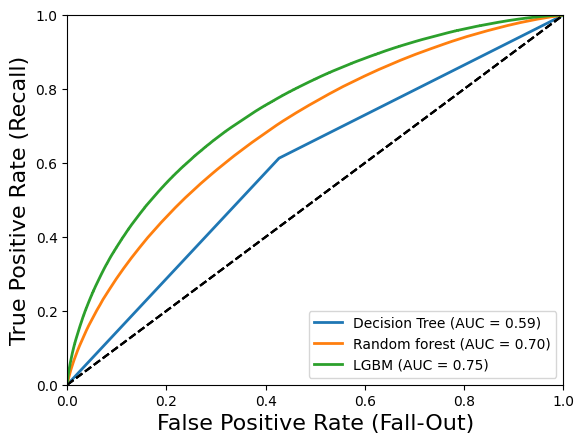

In [12]:
# 가장 큰 데이타셋에 대해서 ROC 커브 그리기
for model_name, model_roc_curve in roc_curves.items():
    fpr, tpr = model_roc_curve[-1]      # select the ROC curve for the largest dataset size
    plot_roc_curve(fpr, tpr, label=f'{model_name} (AUC = {auc_scores[model_name][-1]:.2f})')
    
plt.legend()
plt.show()

# 실제 예측값 확인

In [13]:
user_id = 42

In [14]:
def recommend_top_n(user_id, model, n=5):
    # 아직 유저가 평가하지 않은 애니 가져오기
    user_data = data[data['user_id'] == user_id]
    rated_anime = user_data['anime_id'].unique()
    unrated_animes = item_features[~item_features.index.isin(rated_anime)]
    
    # 유저 정보 붙여주기
    user_features_df = user_features.loc[user_id]
    unrated_animes = unrated_animes.assign(**user_features_df)
    
    # 해당 유저 대상으로 모델 예측
    unrated_animes['predicted_rating'] = model.predict_proba(unrated_animes)[:, 1]
    
    # 상위 N개의 평점 예측
    top_n_animes = unrated_animes.sort_values('predicted_rating', ascending=False).head(n)
    
    return top_n_animes

In [15]:
# 특정 유저에 대한 상위 n개 예측 생성
top_n = recommend_top_n(user_id, models['LGBM'], n=5)[['predicted_rating']]

# top n개 예측의 상세 정보
top_n_details = top_n.merge(animes, how='left', left_index=True, right_on='anime_id')

print(f'Top 5 anime recommendations for user {user_id}')
display(top_n_details)

Top 5 anime recommendations for user 42


,predicted_rating,anime_id,type,anime_total_rating,members,name,genre
6664,0.425695,7915,OVA,6.01,378,Otaku no Seiza,"Comedy, Parody"
12060,0.425695,3643,OVA,5.64,345,Mahou no Rouge Lipstick,Hentai
12219,0.425695,4497,OVA,5.12,460,Kijutsushi x Majutsushi: Osaka Tanteibu no Jik...,Hentai
7665,0.425695,9337,OVA,5.17,820,Mayo Elle Otoko no Ko,"Comedy, School"
5064,0.425695,6492,OVA,6.56,400,Minky Momo in Tabidachi no Eki,"Drama, Fantasy, Magic, Shoujo"


In [16]:
# 좋은 평점을 준 애니 검색
user_ratigns = ratings[ratings['user_id'] == user_id]
well_rated_animes = user_ratigns[user_ratigns['rating'] >= user_ratigns['rating'].mean()]

# 상세 정보 조회
well_rated_details = animes[animes['anime_id'].isin(well_rated_animes['anime_id'])]

# 평점 정보를 포함한 좋은 평점 정보 출력
well_rated_details = well_rated_details.merge(well_rated_animes[['anime_id', 'rating']], on='anime_id', how='inner')
well_rated_details.head()

,anime_id,type,anime_total_rating,members,name,genre,rating
0,14075,TV,8.17,259900,Zetsuen no Tempest,"Action, Drama, Fantasy, Magic, Mystery, Psycho...",10
1,269,TV,7.95,624055,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",10
2,855,TV,7.45,72790,Strawberry Panic,"Drama, Romance, School, Shoujo Ai",10
3,143,TV,7.05,42927,Kannazuki no Miko,"Drama, Magic, Mecha, Romance, Shoujo Ai, Shoun...",9


In [17]:
sample_idx = data[data.user_id == user_id].index[0]
X_test[X_test.index == sample_idx]

,User-AvgRating,User-NumRatings,Item-NumRatings,chan,ga,movie,ni,no,special,specials,...,to,wa,Type-Movie,Type-Music,Type-ONA,Type-OVA,Type-Special,Type-TV,members,anime_total_rating
2901,9.0,6,1472,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,42927,7.05


In [18]:
user_features[user_features.index == user_id]

,User-AvgRating,User-NumRatings
user_id,,
42,9.0,6


# LIME

In [19]:
from lime.lime_tabular import LimeTabularExplainer

# load LGBM model
model = models['LGBM']

# select an instance
instance = X_test[X_test.index == sample_idx].values[0]

# init explainer
explainer = LimeTabularExplainer(X_train_sample.values,
                                 feature_names=X_train_sample.columns,
                                 class_names=['0', '1'],
                                 verbose=True,
                                 mode='classification')

# explain predictions
exp = explainer.explain_instance(instance, model.predict_proba)

# visualize explanation
exp.show_in_notebook(show_table=True)


Intercept 0.6269039132097235
Prediction_local [0.28896599]
Right: 0.28850561304350836


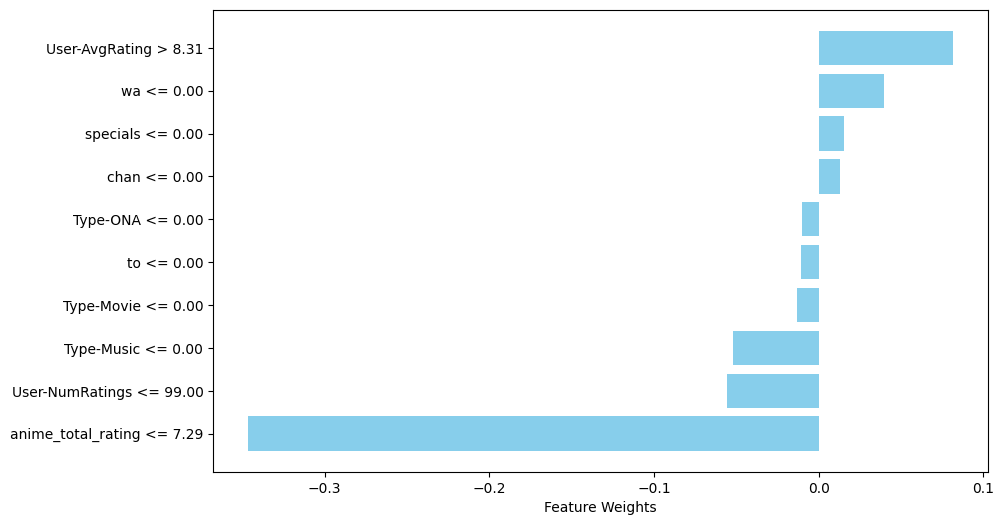

In [20]:
# 피쳐 리스트 및 그에 해당하는 가중치
features = exp.as_list()

# 가중치 절대값 크기에 따라 피쳐 정렬
features.sort(key=lambda x: x[1], reverse=True)

# 두 리스트로 나누기
features_names, features_weights = zip(*features)

# plot bar
plt.figure(figsize=(10, 6))
plt.barh(features_names, features_weights, color='skyblue')
plt.xlabel('Feature Weights')
plt.gca().invert_yaxis()
plt.show()

# SHAP

In [21]:
import shap

# shap tree explainer 인스턴스 생성
shap_explainer = shap.TreeExplainer(model)

# test set 대상으로 shap value 생성
shap_values = shap_explainer.shap_values(X_test)

d:\projects\github\learning\recommendation\recommendation\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [22]:
# 테스트 셋 내의 한 인스턴스에 대해 시각화
# 기본값으로부터 (모델이 셋팅한 베이스라인, shap_explainer_value) 얼마나 각 피쳐가 출력 값을 밀어냈는지 계산

shap.initjs()
shap.force_plot(
    shap_explainer.expected_value, 
    shap_values[X_test.index.get_loc(sample_idx)],
    X_test.iloc[1,:]
)

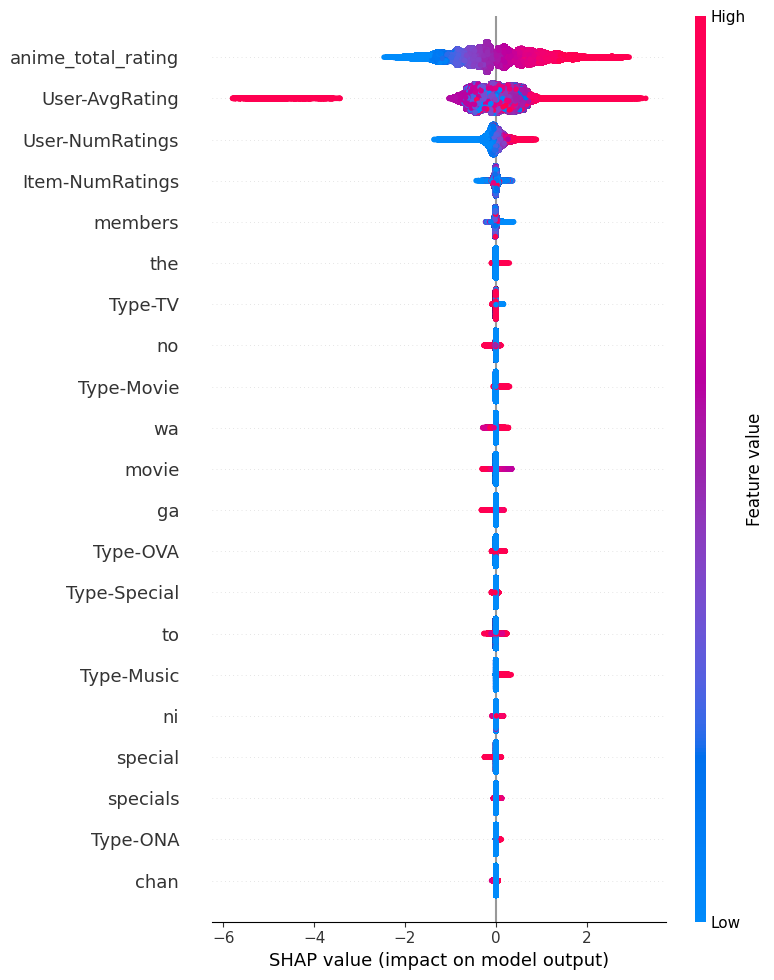

In [ ]:
shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])